In [252]:
from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import pickle as pickle
import re
from functools import reduce 
import operator
from sklearn.feature_extraction.text import TfidfVectorizer


In [88]:
%%time
# Read the Pre-Processed data
restaurant_file = pd.read_csv('processed_data/cleaned_restaurants.csv')
restaurant_file = restaurant_file.drop(labels="Unnamed: 0", axis=1)
review_file     = pd.read_csv('processed_data/cleaned_reviews.csv')
review_file     = review_file.drop(labels="Unnamed: 0", axis=1) 

Wall time: 37 s


In [259]:
%%time
# Convert in Unicode
# seperate topic relavant data from sentiment relavent data
review_file['topic_text'] = [u''+str(txt).replace('.','').replace('\\n','') for txt in review_file.topic_text]
review_file['sentiment_text'] = [u''+str(txt).replace('.','').replace('\\n','') for txt in review_file.sentiment_text]
review_file['text'] = [u''+str(txt) for txt in review_file.text]
review_file['review_length'] = review_file.text.map(len)

Wall time: 7.21 s


[Text(-12.415000000000013, 0.5, 'Number of Reviews')]

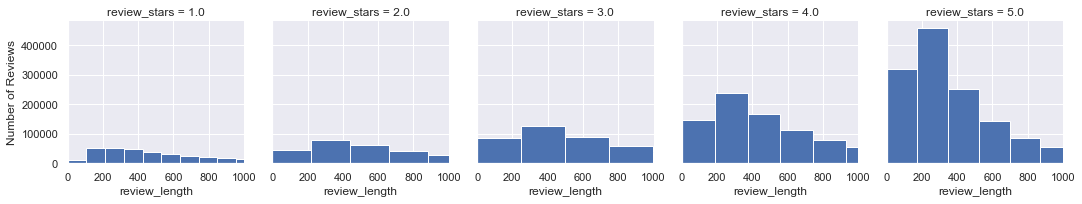

In [260]:
#let's check the distribution of the reviews by length of comments
ax = sns.FacetGrid(data=review_file, col='review_stars', xlim=(0, 1000)).map(plt.hist, 'review_length', bins=50)
ax.axes[0][0].set(ylabel='Number of Reviews')

In [261]:
#It's interesting that five star reivews are more verbose
#print(review_file.loc[review_file['review_stars']==1.0])


In [262]:
pos_reviews_sent  = review_file.sentiment_text[review_file.review_stars>3].values
neg_reviews_sent  = review_file.sentiment_text[review_file.review_stars<3].values
pos_reviews_topic = review_file.topic_text[review_file.review_stars>3].values
neg_reviews_topic = review_file.topic_text[review_file.review_stars<3].values

all_reviews_topic = review_file.topic_text.values
all_reviews_sent  = review_file.sentiment_text.values

print('Postive  Reviews: {:,}'.format(len(pos_reviews_topic)))
print('Negative Reviews: {:,}'.format(len(neg_reviews_topic)))

Postive  Reviews: 2,373,347
Negative Reviews: 693,326


In [263]:
pos_reviews_topic = pos_reviews_sent
neg_reviews_topic = neg_reviews_sent
all_reviews_topic = all_reviews_sent

In [264]:
#Take our additional stopwords
#from sklearn.feature_extraction import text
#extra_words = ['like','did','said','ok', 've', 'got']
#stop_words = text.ENGLISH_STOP_WORDS.union(extra_words)

In [265]:
stop_words = [line.rstrip('\n') for line in open('config/stopwords.txt', 'r', encoding='utf-8')] 
neg_words  = [line.rstrip('\n') for line in open('config/stopwords.txt', 'r', encoding='utf-8')]
stop_words = stop_words + neg_words

In [266]:
# Set max features for data vertorication
max_features=5000

In [267]:
# Tokenize the text
def tokenizer(x):
    return ( w for w in str(x).split() if len(w) >3)

In [268]:
%%time
#TF-IDF
# Create a vectorizer object to generate term document counts
tfidf_pos = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.5,
                        tokenizer = tokenizer,ngram_range=(1,1), max_features=max_features)
                        #ngram_range=(1,1), token_pattern='[a-z][a-z]+', max_features=max_features)

tfidf_neg = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        tokenizer = tokenizer,ngram_range=(1,1), max_features=max_features)
                        #ngram_range=(1,1), token_pattern='[a-z][a-z]+', max_features=max_features)

tfidf_all = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        tokenizer = tokenizer,ngram_range=(1,1), max_features=max_features)
                        #ngram_range=(1,1), token_pattern='[a-z][a-z]+', max_features=max_features)

#  Stats
## Wall time: 2min 47s

Wall time: 0 ns


In [269]:
%%time
# Vectorize Data
neg_vectors  = tfidf_neg.fit_transform(neg_reviews_topic)
pos_vectors  = tfidf_pos.fit_transform(pos_reviews_topic)
all_vectors  = tfidf_all.fit_transform(all_reviews_topic)

#  Stats
## Wall time: 1min 25s

Wall time: 2min 49s


In [270]:
with open('pickles/topic_term_vector_all.pk','wb') as f:
    pickle.dump(tfidf_all, f)
with open('pickles/topic_term_vector_pos.pk','wb') as f:
    pickle.dump(tfidf_pos, f)
with open('pickles/topic_term_vector_neg.pk','wb') as f:
    pickle.dump(tfidf_neg, f)

In [271]:
neg_feature_names = np.array(tfidf_neg.get_feature_names())
pos_feature_names = np.array(tfidf_pos.get_feature_names())
all_feature_names = np.array(tfidf_all.get_feature_names())

In [272]:
#with open('pickles/neg_topic_vectors_'+str(max_features)+'.pk', 'wb') as fin:
#    pickle.dump(neg_vectors, fin)
with open('pickles/neg_topic_features_'+str(max_features)+'.pk', 'wb') as fin:
    pickle.dump(np.array(tfidf_neg.get_feature_names()), fin)    

In [273]:
#with open('pickles/pos_topic_vectors_'+str(max_features)+'.pk', 'wb') as fin:
#    pickle.dump(pos_vectors, fin)
with open('pickles/pos_topic_features_'+str(max_features)+'.pk', 'wb') as fin:
    pickle.dump(np.array(tfidf_pos.get_feature_names()), fin)    

In [274]:
#with open('pickles/all_topic_vectors_'+str(max_features)+'.pk', 'wb') as fin:
#    pickle.dump(all_vectors, fin)
with open('pickles/all_topic_features_'+str(max_features)+'.pk', 'wb') as fin:
    pickle.dump(np.array(tfidf_all.get_feature_names()), fin) 

In [275]:
#with open('pickles/neg_topic_vectors_'+str(max_features)+'.pk', 'rb') as fin:
#    neg_vectors = pickle.load(fin)
with open('pickles/neg_topic_features_'+str(max_features)+'.pk', 'rb') as fin:
    neg_feature_names = pickle.load(fin)

In [276]:
#with open('pickles/pos_topic_vectors_'+str(max_features)+'.pk', 'rb') as fin:
#    pos_vectors = pickle.load(fin)
with open('pickles/pos_topic_features_'+str(max_features)+'.pk', 'rb') as fin:
    pos_feature_names = pickle.load(fin)

In [277]:
#with open('pickles/all_topic_vectors_'+str(max_features)+'.pk', 'rb') as fin:
#    all_vectors = pickle.load(fin)
with open('pickles/all_topic_features_'+str(max_features)+'.pk', 'rb') as fin:
    all_feature_names = pickle.load(fin)

In [278]:
all_vectors.get_shape()

(3527902, 5000)

# LSA

In [285]:
NUM_TOPICS = 50

In [286]:
%%time
# LSA
from gensim import corpora, models, similarities, matutils

# Convert sparse matrix of counts to a gensim corpus
# Need to transpose it for gensim which wants terms by docs instead of docs by terms
tfidf_pos_corpus = matutils.Sparse2Corpus(pos_vectors.transpose())
tfidf_neg_corpus = matutils.Sparse2Corpus(neg_vectors.transpose())
tfidf_all_corpus = matutils.Sparse2Corpus(all_vectors.transpose())

# Row indices
id2word_pos = dict((v,k) for k,v in tfidf_pos.vocabulary_.items())
id2word_neg = dict((v,k) for k,v in tfidf_neg.vocabulary_.items())
id2word_all = dict((v,k) for k,v in tfidf_all.vocabulary_.items())

# This is a hack for Python 3!
id2word_pos = corpora.Dictionary.from_corpus(tfidf_pos_corpus, id2word=id2word_pos)
id2word_neg = corpora.Dictionary.from_corpus(tfidf_neg_corpus, id2word=id2word_neg)
id2word_all = corpora.Dictionary.from_corpus(tfidf_all_corpus, id2word=id2word_all)

#  Stats
## Wall time: 1min 21s

Wall time: 1min 45s


In [287]:
%%time
# create LSA model
lsi_pos = models.LsiModel(tfidf_pos_corpus, id2word=id2word_pos, num_topics=NUM_TOPICS)
lsi_neg = models.LsiModel(tfidf_neg_corpus, id2word=id2word_neg, num_topics=NUM_TOPICS)
lsi_all = models.LsiModel(tfidf_all_corpus, id2word=id2word_all, num_topics=NUM_TOPICS)

#  Stats
## Wall time: 13min 3s

Wall time: 7min 33s


In [288]:
%%time
# negative values in LSA topics are annoying
# let's see if we can fix that with NMF
from sklearn.decomposition import NMF

Wall time: 0 ns


In [289]:
%%time
# change num_topics
num_topics = NUM_TOPICS

In [290]:
%%time
nmf_pos = NMF(n_components=num_topics)
W_pos = nmf_pos.fit_transform(pos_vectors)
H_pos = nmf_pos.components_

In [291]:
%%time
nmf_neg = NMF(n_components=num_topics)
W_neg = nmf_neg.fit_transform(neg_vectors)
H_neg = nmf_neg.components_

In [292]:
%%time
nmf_all = NMF(n_components=num_topics)
W_all = nmf_all.fit_transform(all_vectors)
H_all = nmf_all.components_

### Checkpointing: dump processed won in pickles

In [301]:
# Save models for future use
with open('pickles/neg_topic_model.pk', 'wb') as fin:
    pickle.dump(lsi_neg, fin)
with open('pickles/pos_topic_model.pk', 'wb') as fin:
    pickle.dump(lsi_pos, fin)
with open('pickles/all_topic_model.pk', 'wb') as fin:
    pickle.dump(lsi_all, fin)        

In [302]:
# Save models for future use
with open('pickles/neg_nmf_model.pk', 'wb') as fin:
    pickle.dump(nmf_neg, fin)
with open('pickles/pos_nmf_model.pk', 'wb') as fin:
    pickle.dump(nmf_pos, fin)
with open('pickles/all_nmf_model.pk', 'wb') as fin:
    pickle.dump(nmf_all, fin)

##### Load saved pickles and resume

In [119]:
max_features=2500
num_topics  =100

In [120]:
with open('pickles/all_topic_model.pk', 'rb') as fin:
    lsi_all = pickle.load(fin)
with open('pickles/pos_topic_model.pk', 'rb') as fin:
    lsi_pos = pickle.load(fin)
with open('pickles/neg_topic_model.pk', 'rb') as fin:
    lsi_neg = pickle.load(fin)

In [121]:
with open('pickles/neg_nmf_model.pk', 'rb') as fin:
    nmf_neg = pickle.load(fin)
with open('pickles/pos_nmf_model.pk', 'rb') as fin:
    nmf_pos = pickle.load(fin)
with open('pickles/all_nmf_model.pk', 'rb') as fin:
    nmf_all = pickle.load(fin)

C:\Users\asad_\Anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator NMF from version 0.21.3 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\asad_\Anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator NMF from version 0.21.3 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\asad_\Anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator NMF from version 0.21.3 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [122]:
with open('pickles/all_topic_features_'+str(max_features)+'.pk', 'rb') as fin:
    all_feature_names = pickle.load(fin)

In [123]:
with open('pickles/pos_topic_features_'+str(max_features)+'.pk', 'rb') as fin:
    pos_feature_names = pickle.load(fin)

In [124]:
with open('pickles/neg_topic_features_'+str(max_features)+'.pk', 'rb') as fin:
    neg_feature_names = pickle.load(fin)

In [125]:
with open('pickles/topic_term_vector.pk', 'rb') as fin:
    term_vector = pickle.load(fin)

In [293]:
def get_topic_list(model, feature_names, num_topics, no_top_words):
    lst = []
    for topic_idx, topic in enumerate(model.components_):
        if topic_idx < num_topics:
            #print("{:11}".format("Topic %d:" %(topic_idx)), end='')
            #print(", ".join(['{:04.3f}*'.format(topic[i])+feature_names[i] for i in topic.argsort()[:-no_top_words-1:-1]]))
            lst.append('/'.join(sort_list([feature_names[i]+" " for i in topic.argsort()[:-no_top_words-1:-1]])))
    return((list(sorted(set(lst)))))

In [294]:
def get_topic_map(model, feature_names, num_topics, no_top_words):
    dicty = {}
    for topic_idx, topic in enumerate(model.components_):
        if topic_idx < num_topics:
            dicty[topic_idx]='/'.join(sort_list([feature_names[i]+" " for i in topic.argsort()[:-no_top_words-1:-1]]))
    return dicty

In [295]:
def display_topics(model, feature_names, num_topics, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        if topic_idx < num_topics:
            print("{:11}".format("Topic %d:" %(topic_idx)), end='')
            print(", ".join(['{:04.3f}*'.format(topic[i])+feature_names[i] \
                             for i in topic.argsort()[:-no_top_words-1:-1]]))

In [296]:
def topic_to_text(topic):
    str = ''
    for elem in list(topic)[1].split('+')[:6]:
        str+= '/'.join(re.findall(r'"([^"]*)"', elem))+' '
    topics.append(str)

In [297]:
def sort_list(lst):
    return list(sorted(set(reduce(operator.concat, lst).split())))

In [298]:
topic_list = []
no_topics = num_topics
no_top_words = 6

topic_list.extend(get_topic_list(nmf_all, all_feature_names, no_topics, no_top_words))
topic_list.extend(get_topic_list(nmf_pos, pos_feature_names, no_topics, no_top_words))
topic_list.extend(get_topic_list(nmf_neg, neg_feature_names, no_topics, no_top_words))

In [299]:
display_topics(nmf_all, all_feature_names, no_topics, no_top_words)

Topic 0:   33.337*table, 5.764*seat, 3.771*waiter, 3.330*reservation, 2.421*bring, 2.232*waitress
Topic 1:   21.926*love, 0.749*favorite, 0.729*atmosphere, 0.612*husband, 0.567*family, 0.444*year
Topic 2:   17.797*food, 0.987*quality, 0.644*good-service, 0.490*atmosphere, 0.483*not-good, 0.364*great-service
Topic 3:   12.232*pizza, 1.139*crust, 0.937*good-pizza, 0.929*slice, 0.683*pepperoni, 0.619*wing
Topic 4:   12.691*good, 0.303*mexican-food, 0.232*not-great, 0.201*town, 0.179*chinese-food, 0.177*recommend
Topic 5:   10.957*burger, 0.773*good-burger, 0.666*shake, 0.609*bacon, 0.574*patty, 0.461*sweet-potato
Topic 6:   24.622*great, 0.568*atmosphere, 0.476*definitely, 0.397*highly-recommend, 0.375*friendly-service, 0.372*fantastic
Topic 7:   13.027*sushi, 1.141*chef, 0.969*sashimi, 0.784*fish, 0.750*quality, 0.733*good-sushi
Topic 8:   12.118*dollar, 0.899*charge, 0.665*bill, 0.599*spend, 0.574*cost, 0.457*person
Topic 9:   20.075*taco, 1.211*shrimp, 1.145*tuesday, 1.138*street, 0.92

In [300]:
get_topic_map(nmf_all, all_feature_names, no_topics, no_top_words)

{0: 'bring/reservation/seat/table/waiter/waitress',
 1: 'atmosphere/family/favorite/husband/love/year',
 2: 'atmosphere/food/good-service/great-service/not-good/quality',
 3: 'crust/good-pizza/pepperoni/pizza/slice/wing',
 4: 'chinese-food/good/mexican-food/not-great/recommend/town',
 5: 'bacon/burger/good-burger/patty/shake/sweet-potato',
 6: 'atmosphere/definitely/fantastic/friendly-service/great/highly-recommend',
 7: 'chef/fish/good-sushi/quality/sashimi/sushi',
 8: 'bill/charge/cost/dollar/person/spend',
 9: 'al-pastor/carne/shrimp/street/taco/tuesday',
 10: 'bean/burrito/chip/fish/mexican-food/salsa',
 11: 'feel/home/like/more/much/not-feel',
 12: 'chicken/curry/rice/tender/waffle/wing',
 13: 'couple/second-time/time/visit/week/year',
 14: 'customer/fast/great-customer/quick/service/slow',
 15: 'bread/good-sandwich/pastrami/pulled-pork/sandwich/turkey',
 16: 'attentive/clean/fast/friendly/helpful/staff',
 17: 'absolutely/amazing/definitely/highly-recommend/not-wait/thank',
 18: '

In [162]:
with open('config/all_topics.txt', 'w') as f:
    f.write('\n'.join([str(key)+";"+str(value) for key, value in get_topic_map(nmf_all, all_feature_names, no_topics, no_top_words).items()]))

In [163]:
with open('config/neg_topics.txt', 'w') as f:
    f.write('\n'.join([str(key)+";"+str(value) for key, value in get_topic_map(nmf_neg, neg_feature_names, no_topics, no_top_words).items()]))

In [164]:
with open('config/pos_topics.txt', 'w') as f:
    f.write('\n'.join([str(key)+";"+str(value) for key, value in get_topic_map(nmf_pos, pos_feature_names, no_topics, no_top_words).items()]))

In [63]:
#with open('config/topics.csv', 'w+') as f:
#    f.write('\n'.join(topic_list))

In [187]:
topic_desc_map = {}
with open('config/topic_map.txt', 'r') as f:
    topic_desc_map = {line.split(';')[0]: line.split(';')[1].replace('\n','') for line in f.readlines()}

neg_topic_map = {}
pos_topic_map = {}
all_topic_map = {}

with open('config/pos_topics.txt', 'r') as f:
    pos_topic_map = {line.split(';')[0]: line.split(';')[1].replace('\n','') for line in f.readlines()}
with open('config/neg_topics.txt', 'r') as f:
    neg_topic_map = {line.split(';')[0]: line.split(';')[1].replace('\n','') for line in f.readlines()}
with open('config/all_topics.txt', 'r') as f:
    all_topic_map = {line.split(';')[0]: line.split(';')[1].replace('\n','') for line in f.readlines()}

In [241]:
new_review_text = review_file['text'][5]
new_topic_text  = review_file['topic_text'][5]

In [247]:
print(new_review_text.replace('\\n','\n'))

I've been a frequent at this place for years, enough that the managers pretty much recognize my whole family. And I have to say, this is probably my favorite Chinese place for lunch.

First of all, the place is HUGE. My relatives have booked this place as a venue for weddings, events, gatherings, and we usually get a good experience. On some days when you come at a busy time, it's not that bad of a wait because of how many tables there are! I remember waiting in a line past the door a few times to be seated, but maybe this has changed?

FOOD! I honestly think it's great here, though it is a bit expensive for what it offers. I prefer the lunch dim sum, letting them wheel carts as you take your pick. It's nice because I'm definitely not a decisive person, so I usually just get the tastiest looking stuff on the carts. A favorite is the crap shrimp ball things (? lol), the siu mai, dumplings, they're all very good. I also love the green vegetable plates or the scallops here, they're cooked

In [248]:
print(new_topic_text.replace('\\n','\n'))

manager family venue day wait table remember wait line door time seat food prefer lunch dim_sum wheel cart pick person stuff cart shrimp ball dumpling love plate scallop cook overcook meat service cart lady speak drink sauce plate ask people reason find dinner experience bit love lunch think fun drop quality will


In [243]:
new_text_vec = term_vector.transform([new_topic_text])

In [250]:
text_all = nmf_all.transform(new_text_vec)

In [251]:
np.argmax(text_all)

98

In [245]:
all_topic_map[str(np.argmax(text_all))]

'combo/gyro/hummus/pita/plate/share'

In [246]:
topic_desc_map[all_topic_map[str(np.argmax(text_all))]]

'Arabian Food'

In [229]:
text_pos = nmf_pos.transform(new_text_vec)

In [233]:
all_topic_map[str(np.argmax(text_pos))]

'crust/delivery/pasta/pepperoni/pizza/slice'

In [235]:
topic_desc_map[all_topic_map[str(np.argmax(text_pos))]]

'Pizza & Delivery'

In [236]:
text_neg = nmf_neg.transform(new_text_vec)

In [238]:
all_topic_map[str(np.argmax(text_neg))]

'combo/gyro/hummus/pita/plate/share'

In [144]:
topics = []
for topic in lsi_all.show_topics():
    str = ''
    for elem in list(topic)[1].split('+')[:6]:
        str+= '/'.join(re.findall(r'"([^"]*)"', elem))+' '
    topics.append(str)

In [145]:
with open ('config/topic_map1.csv','w+') as f:
    f.write('\n'.join(topics))

['food service time love dollar wait ',
 'food service love pizza chicken dollar ',
 'love dollar wait food minute table ',
 'pizza service chicken burger dollar taco ',
 'service food pizza sushi staff customer ',
 'time chicken wait minute pizza food ',
 'burger sushi time roll chicken cheese ',
 'time chicken dollar sushi drink price ',
 'sushi time roll chicken wait dollar ',
 'dollar sushi roll time wait staff ',
 'staff wait minute chicken dollar menu ',
 'taco sandwich fish dollar salsa salad ',
 'dollar staff wait chicken menu server ',
 'sandwich drink chicken taco lunch wait ',
 'drink sandwich dish sushi chicken lunch ',
 'lunch sandwich menu dinner salad cheese ',
 'price salad dollar staff breakfast chicken ',
 'price salad dollar drink breakfast lunch ',
 'menu price salad vegas friend taste ',
 'server drink menu taste lunch chicken ',
 'server salad beer lunch drink taste ',
 'salad location cheese friend enjoy look ',
 'breakfast beer lunch vegas sandwich steak ',
 'be

In [126]:
lsi_all.show_topics()

[(0,
  '0.445*"food" + 0.266*"service" + 0.235*"time" + 0.217*"love" + 0.153*"dollar" + 0.141*"wait" + 0.138*"chicken" + 0.127*"drink" + 0.121*"menu" + 0.117*"table"'),
 (1,
  '-0.764*"food" + -0.236*"service" + 0.223*"love" + 0.222*"pizza" + 0.166*"chicken" + 0.157*"dollar" + 0.127*"salad" + 0.120*"burger" + 0.104*"cheese" + 0.102*"sauce"'),
 (2,
  '-0.913*"love" + 0.154*"dollar" + 0.132*"wait" + -0.115*"food" + 0.103*"minute" + 0.099*"table" + 0.064*"drink" + 0.061*"server" + 0.059*"time" + 0.058*"tell"'),
 (3,
  '0.852*"pizza" + 0.323*"service" + -0.173*"chicken" + -0.123*"burger" + -0.096*"dollar" + -0.092*"taco" + -0.084*"sushi" + -0.084*"rice" + -0.079*"roll" + 0.076*"crust"'),
 (4,
  '-0.839*"service" + 0.369*"food" + 0.315*"pizza" + -0.106*"sushi" + 0.100*"staff" + -0.089*"customer" + 0.068*"wait" + -0.063*"roll" + 0.040*"cheese" + 0.039*"chicken"'),
 (5,
  '0.448*"time" + -0.401*"chicken" + 0.367*"wait" + 0.212*"minute" + -0.181*"pizza" + -0.181*"food" + -0.169*"dollar" + -0.1

In [102]:
# LSA
from gensim import corpora, models, similarities, matutils

# Convert sparse matrix of counts to a gensim corpus
# Need to transpose it for gensim which wants terms by docs instead of docs by terms
tfidf_pos_corpus = matutils.Sparse2Corpus(p_vectors.transpose())
tfidf_neg_corpus = matutils.Sparse2Corpus(n_vectors.transpose())

# Row indices
id2word_pos = dict((v,k) for k,v in tfidf_pos.vocabulary_.items())
id2word_neg = dict((v,k) for k,v in tfidf_neg.vocabulary_.items())

# This is a hack for Python 3!
id2word_pos = corpora.Dictionary.from_corpus(tfidf_pos_corpus, id2word=id2word_pos)
id2word_neg = corpora.Dictionary.from_corpus(tfidf_neg_corpus, id2word=id2word_neg)

In [103]:
# create LSA model
num_topics = 10
lsi_pos = models.LsiModel(tfidf_pos_corpus, id2word=id2word_pos, num_topics=num_topics)
lsi_neg = models.LsiModel(tfidf_neg_corpus, id2word=id2word_neg, num_topics=num_topics)

In [111]:
len(lsi_pos.get_topics())

10

In [104]:
topics_to_print = 5

# look at top positive topics
print('Top %d topics for POSITIVE reviews' %(topics_to_print))
print('-'*33)
pprint(lsi_pos.show_topics()[0:topics_to_print])

Top 5 topics for POSITIVE reviews
---------------------------------
[(0,
  '0.450*"food" + 0.307*"love" + 0.273*"service" + 0.239*"time" + '
  '0.146*"chicken" + 0.127*"menu" + 0.127*"staff" + 0.124*"dollar" + '
  '0.112*"drink" + 0.104*"salad"'),
 (1,
  '0.702*"food" + -0.575*"love" + 0.239*"service" + -0.139*"pizza" + '
  '-0.107*"chicken" + -0.087*"salad" + -0.069*"sandwich" + -0.068*"cheese" + '
  '-0.067*"burger" + -0.067*"sauce"'),
 (2,
  '-0.746*"love" + -0.372*"food" + 0.157*"dollar" + 0.146*"time" + '
  '0.132*"chicken" + 0.096*"menu" + 0.096*"pizza" + 0.093*"salad" + '
  '0.081*"sauce" + 0.080*"cheese"'),
 (3,
  '-0.912*"service" + 0.331*"food" + 0.144*"staff" + -0.077*"customer" + '
  '0.067*"time" + 0.053*"chicken" + 0.051*"wait" + 0.037*"dollar" + '
  '-0.036*"love" + -0.033*"sushi"'),
 (4,
  '0.838*"time" + -0.305*"chicken" + -0.153*"dollar" + -0.121*"salad" + '
  '0.107*"pizza" + 0.092*"wait" + 0.091*"staff" + -0.088*"taco" + '
  '-0.088*"rice" + -0.087*"sauce"')]


In [105]:
topics_to_print = 5
# look at top negative topics
print('Top %d topics for NEGATIVE reviews' %(topics_to_print))
print('-'*33)
pprint(lsi_neg.show_topics()[0:topics_to_print])

Top 5 topics for NEGATIVE reviews
---------------------------------
[(0,
  '0.398*"food" + 0.234*"service" + 0.231*"wait" + 0.222*"time" + '
  '0.204*"minute" + 0.177*"table" + 0.176*"dollar" + 0.149*"drink" + '
  '0.144*"server" + 0.135*"tell"'),
 (1,
  '0.474*"wait" + 0.393*"minute" + -0.351*"dollar" + -0.242*"chicken" + '
  '-0.205*"taste" + 0.194*"table" + -0.158*"price" + 0.127*"seat" + '
  '-0.125*"sauce" + -0.112*"salad"'),
 (2,
  '-0.790*"food" + -0.270*"service" + 0.253*"dollar" + 0.204*"pizza" + '
  '0.120*"tell" + 0.109*"minute" + 0.093*"table" + 0.089*"salad" + '
  '0.088*"wait" + 0.087*"chicken"'),
 (3,
  '-0.777*"pizza" + 0.349*"dollar" + -0.234*"time" + 0.175*"drink" + '
  '0.135*"table" + -0.123*"service" + 0.104*"server" + -0.094*"chicken" + '
  '0.081*"burger" + -0.080*"location"'),
 (4,
  '0.650*"service" + -0.368*"chicken" + -0.259*"wait" + -0.247*"food" + '
  '0.204*"customer" + -0.181*"minute" + 0.180*"dollar" + -0.167*"taste" + '
  '-0.103*"rice" + -0.096*"sauce"

In [106]:
%%time
# negative values in LSA topics are annoying
# let's see if we can fix that with NMF
from sklearn.decomposition import NMF

# change num_topics
num_topics = 6

nmf_pos = NMF(n_components=num_topics)
W_pos = nmf_pos.fit_transform(p_vectors)
H_pos = nmf_pos.components_

nmf_neg = NMF(n_components=num_topics)
W_neg = nmf_neg.fit_transform(n_vectors)
H_neg = nmf_neg.components_

Wall time: 48.7 s


In [70]:
def display_topics(model, feature_names, num_topics, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        if topic_idx < num_topics:
            print("{:11}".format("Topic %d:" %(topic_idx)), end='')
            print(", ".join(['{:04.3f}*'.format(topic[i])+feature_names[i] \
                             for i in topic.argsort()[:-no_top_words-1:-1]]))

no_topics = num_topics
no_top_words = 6

print('Top topics + words for POSITIVE reviews')
print('-'*39)
display_topics(nmf_pos, tfidf_pos.get_feature_names(), no_topics, no_top_words)

print('\nTop topics + words for NEGATIVE reviews')
print('-'*39)
display_topics(nmf_neg, tfidf_neg.get_feature_names(), no_topics, no_top_words)

Top topics + words for POSITIVE reviews
---------------------------------------
Topic 0:   4.431*chicken, 3.873*dollar, 3.397*menu, 2.810*salad, 2.776*burger, 2.489*lunch
Topic 1:   12.800*food, 1.064*staff, 0.587*price, 0.547*atmosphere, 0.527*drink, 0.517*server
Topic 2:   12.552*love, 0.550*staff, 0.496*atmosphere, 0.366*family, 0.316*husband, 0.238*location
Topic 3:   12.291*service, 1.128*customer, 0.469*atmosphere, 0.415*star, 0.365*thank, 0.345*price
Topic 4:   11.093*pizza, 0.987*crust, 0.771*salad, 0.760*slice, 0.757*cheese, 0.740*wing
Topic 5:   8.381*will, 7.179*time, 1.050*staff, 1.009*visit, 0.906*vegas, 0.632*wait

Top topics + words for NEGATIVE reviews
---------------------------------------
Topic 0:   4.574*time, 3.337*will, 2.989*service, 2.549*server, 2.378*drink, 2.350*table
Topic 1:   5.990*wait, 5.017*minute, 1.659*table, 1.363*seat, 1.312*hour, 0.755*tell
Topic 2:   9.269*food, 2.394*service, 0.801*price, 0.768*quality, 0.406*star, 0.387*buffet
Topic 3:   8.166*p

In [65]:
# look at a random positive and negative reviews
print('Positive Review')
review_num = np.random.randint(0, high=len(p_reviews))
print(review_num)
print(review_file.text[review_file.review_stars>3].iloc[review_num])

print('\nNegative Review')
review_num = np.random.randint(0, high=len(n_reviews))
print(review_num)
print(review_file.text[review_file.review_stars<3].iloc[review_num])

Positive Review
1903275
This is the best food I have had since arriving in Phoenix.  Traditional Balkan cuisine, perfectly done, and served up with lots of sour cream and adjar- the sweet red pepper sauce.  We had the sausage( get the small), stuffed peppers, chicken soup, a gyro that is authentic and fresh and so much better than the ordinary ones you get after a night of swilling beer.  All of it was great.  You need to try this.

Negative Review
81246
Went here for brunch this past weekend... AWFUL AWFUL SERVICE!!! The food was decent, but man I can't stress enough how bad the service was. The hostesses were pleasant and were kind enough to take out coats... but things went downhill very quickly after. \nOur waiter didn't appear until 30 minutes after we had helped ourselves to the buffet style brunch. He was cold, and seemed uninterested in his job. While making their rounds, they constantly ignored our corner of the room, leaving us with piles of dirty plates and empty coffee mugs

In [66]:
# compute cosine similarities of this review with all other reviews in the new space
import sklearn.metrics.pairwise as smp

cosines = {}
for ind, review in enumerate(W_pos):
    similarity = smp.cosine_similarity(W_pos[review_num].reshape(1,-1), review.reshape(1,-1))
    cosines[ind] = similarity[0][0]

KeyboardInterrupt: 

In [ ]:
# get top 3 matching reviews
for n in sorted(cosines, key=cosines.get, reverse=True)[1:4]:
    print('-'*50)
    print('>> Similarity {:.3f}'.format(cosines[n]))
    print(random_pos[n])
print('-'*50)

In [23]:

from sklearn.feature_extraction.text import CountVectorizer

# Create a vectorizer object to generate term document counts
cv_pos = CountVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

cv_neg = CountVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

# Get random subset of reviews
np.random.seed(38)
num_reviews = 15000
cv_random_neg = np.random.choice(n_reviews, size=num_reviews)
cv_random_pos = np.random.choice(p_reviews, size=num_reviews)

# replace words from defined dictionary 'dicty'
cv_random_neg = [replace_words(w, dicty) for w in cv_random_neg]
cv_random_pos = [replace_words(w, dicty) for w in cv_random_pos]

# Get the cv vectors
cv_neg_vectors = cv_neg.fit_transform(cv_random_neg).transpose()
cv_pos_vectors = cv_pos.fit_transform(cv_random_pos).transpose()

In [24]:

# Convert sparse matrix of counts to a gensim corpus
corpus_neg = matutils.Sparse2Corpus(cv_neg_vectors)
corpus_pos = matutils.Sparse2Corpus(cv_pos_vectors)

# save a mapping (dict) of row id to word (token) for later use by gensim 
id2word_cv_pos = dict((v, k) for k, v in cv_pos.vocabulary_.items())
id2word_cv_neg = dict((v, k) for k, v in cv_neg.vocabulary_.items())

In [25]:
print('Postive Reviews:  {:,}'.format(len(p_reviews)))
print('Negative Reviews:  {:,}'.format(len(n_reviews)))

Postive Reviews:  736,919
Negative Reviews:  216,632


In [26]:

%%time
# Create a vectorizer object to generate term document counts
tfidf_pos = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

tfidf_neg = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

# replace words with defined dictionary 'dicty'
pos_reviews = [replace_words(w, dicty) for w in p_reviews]
neg_reviews = [replace_words(w, dicty) for w in n_reviews]

# Get the vectors
neg_vectors = tfidf_neg.fit_transform(n_reviews)
pos_vectors = tfidf_pos.fit_transform(p_reviews)

Wall time: 1min 18s


In [27]:
%%time
# NMF for all reviews
from sklearn.decomposition import NMF

# change num_topics
num_topics = 6

nmf_pos = NMF(n_components=num_topics)
W_pos = nmf_pos.fit_transform(pos_vectors)
H_pos = nmf_pos.components_

nmf_neg = NMF(n_components=num_topics)
W_neg = nmf_neg.fit_transform(neg_vectors)
H_neg = nmf_neg.components_

Wall time: 2min 4s


In [28]:

no_topics = num_topics
no_top_words = 6

print('Topics for POSITIVE reviews')
print('-'*39)
display_topics(nmf_pos, tfidf_pos.get_feature_names(), no_topics, no_top_words)

print('\nTopics for NEGATIVE reviews')
print('-'*39)
display_topics(nmf_neg, tfidf_neg.get_feature_names(), no_topics, no_top_words)

Topics for POSITIVE reviews
---------------------------------------
Topic 0:   2.282*chicken, 1.877*time, 1.820*just, 1.761*ordered, 1.615*delicious, 1.420*salad
Topic 1:   6.102*great, 3.160*service, 2.849*food, 1.256*atmosphere, 1.064*excellent, 0.762*awesome
Topic 2:   7.048*pizza, 1.224*crust, 0.858*wings, 0.572*best, 0.424*pizzas, 0.419*cheese
Topic 3:   4.346*place, 3.819*love, 1.889*amazing, 1.880*staff, 1.824*friendly, 1.786*best
Topic 4:   7.635*good, 2.582*really, 1.904*food, 1.155*nice, 1.110*pretty, 1.042*service
Topic 5:   4.489*sushi, 2.767*happy, 2.628*hour, 1.165*roll, 1.037*rolls, 0.487*bar

Topics for NEGATIVE reviews
---------------------------------------
Topic 0:   3.203*place, 1.713*just, 1.696*good, 1.449*really, 1.397*don, 0.949*great
Topic 1:   2.453*chicken, 1.442*ordered, 1.102*sauce, 1.099*salad, 1.002*rice, 0.914*cheese
Topic 2:   5.358*pizza, 0.798*crust, 0.558*wings, 0.531*cheese, 0.373*sauce, 0.357*pizzas
Topic 3:   2.437*minutes, 1.964*table, 1.707*came

In [29]:

# create topic dictionaries to summarize the topic meanings
pos_topics = {0:'time/order/service', 1:'service/atmosphere', 2:'service/pizza', 
              3:'serivce/atmosphere/staff', 4:'friendly_staff', 5:'bar/happy_hour'}

neg_topics = {0:'beer/people', 1:'food/chicken/salad', 2:'food/pizza', 
              3:'wait/table', 4:'order/time/location', 5:'bad_service'}

In [30]:
# we create dataframes for positive & negative reviews that we can
# later add topic information to
df_pos = review_file[['business_id', 'review_stars', 'text', 'review_length']][review_file.review_stars>3].reset_index()
df_neg = review_file[['business_id', 'review_stars', 'text', 'review_length']][review_file.review_stars<3].reset_index()
df_pos.drop(labels='index', axis=1, inplace=True)
df_neg.drop(labels='index', axis=1, inplace=True)

In [31]:

print('Topic weights : ', W_pos[0])
print('Sum of weights: ', W_pos[0].sum())

Topic weights :  [0.01274134 0.01938411 0.         0.00407995 0.0027115  0.        ]
Sum of weights:  0.03891689170199594


In [32]:

from sklearn.preprocessing import normalize
print('Normalized Topic weights : ', normalize(W_pos[0].reshape(1,-1), norm='l1'))
print('Sum of normalized weights: ', normalize(W_pos[0].reshape(1,-1), norm='l1').sum())

Normalized Topic weights :  [[0.32739864 0.49808983 0.         0.10483746 0.06967407 0.        ]]
Sum of normalized weights:  1.0


In [33]:

# add normalized topic weights to each review
df_pos = pd.concat([df_pos, pd.DataFrame(normalize(W_pos, norm='l1'))], axis=1)
df_neg = pd.concat([df_neg, pd.DataFrame(normalize(W_neg, norm='l1'))], axis=1)

In [34]:

# peek into a dataframe to ensure it worked right
df_neg.head()

,business_id,review_stars,text,review_length,0,1,2,3,4,5
0,44YFU284Z3KDEy25QyVoUw,2.0,This 2 star rating is for the service. Althoug...,518,0.012415,0.013928,0.000000,0.760511,0.000000,0.213146
1,44YFU284Z3KDEy25QyVoUw,2.0,After reading many decent reviews and seeing h...,258,0.834317,0.071897,0.010393,0.000000,0.070177,0.013216
2,44YFU284Z3KDEy25QyVoUw,1.0,The service to grab a seat is slow like 20 min...,366,0.046787,0.004027,0.000404,0.405789,0.300758,0.242234
3,44YFU284Z3KDEy25QyVoUw,2.0,Very disappointed with the lack of flavor in t...,195,0.000000,0.813191,0.016033,0.000000,0.128457,0.042319
4,44YFU284Z3KDEy25QyVoUw,1.0,The wait staff is as nasty as the food. RUDE A...,448,0.039458,0.382742,0.000000,0.111113,0.000000,0.466687


In [35]:

# group by business_id and apply mean/count functions to columns
df_pos_bsns = df_pos.groupby('business_id').agg({'review_stars':'mean', 'text':'count',
                                                 'review_length':'mean',0:'mean', 
                                                 1:'mean', 2:'mean', 3:'mean',
                                                 4:'mean', 5:'mean'}).reset_index()
df_neg_bsns = df_neg.groupby('business_id').agg({'review_stars':'mean', 'text':'count',
                                                 'review_length':'mean',0:'mean', 
                                                 1:'mean', 2:'mean', 3:'mean',
                                                 4:'mean', 5:'mean'}).reset_index()

In [36]:
df_pos_bsns.head(5)

,business_id,review_stars,text,review_length,0,1,2,3,4,5
0,-01XupAWZEXbdNbxNg5mEg,4.488889,45,593.666667,0.256016,0.254983,0.047231,0.163278,0.173443,0.105050
1,-050d_XIor1NpCuWkbIVaQ,4.545120,543,766.480663,0.385385,0.114889,0.013322,0.300914,0.143474,0.042015
2,-092wE7j5HZOogMLAh40zA,4.600000,55,539.727273,0.329510,0.152820,0.014533,0.258739,0.188905,0.055493
3,-0WegMt6Cy966qlDKhu6jA,4.307692,13,467.769231,0.291615,0.237132,0.018235,0.148809,0.220965,0.083244
4,-0tgMGl7D9B10YjSN2ujLA,4.421053,76,399.671053,0.187277,0.308735,0.018388,0.205323,0.201018,0.079258


In [37]:
df_neg_bsns.head()

,business_id,review_stars,text,review_length,0,1,2,3,4,5
0,-01XupAWZEXbdNbxNg5mEg,1.421053,38,601.789474,0.365444,0.178131,0.037723,0.177224,0.080320,0.161158
1,-050d_XIor1NpCuWkbIVaQ,1.607143,84,922.940476,0.451230,0.150766,0.014057,0.204198,0.109618,0.070132
2,-092wE7j5HZOogMLAh40zA,1.294118,34,630.970588,0.157546,0.472303,0.013131,0.042274,0.219311,0.095435
3,-0WegMt6Cy966qlDKhu6jA,1.357143,70,639.171429,0.289390,0.072532,0.013121,0.280011,0.112165,0.232782
4,-0tgMGl7D9B10YjSN2ujLA,1.416667,36,541.527778,0.368271,0.092633,0.007106,0.265700,0.083006,0.183284


In [38]:
# we can read in business info from a saved CSV file
# and add that to our last dataframe

az_df = pd.read_csv('processed_data/restaurants_az.csv')
az_df.drop(labels='Unnamed: 0', axis=1, inplace=True)

In [39]:
# merge business name/city with topic data
df_pos_tot = df_pos_bsns.merge(az_df[['business_id', 'name', 'city', 'stars']], left_on='business_id', 
                               right_on='business_id')[['business_id', 'name', 'city', 'stars', 0, 1, 2, 3, 4, 5]]

df_neg_tot = df_neg_bsns.merge(az_df[['business_id', 'name', 'city', 'stars']], left_on='business_id', 
                               right_on='business_id')[['business_id', 'name', 'city', 'stars', 0, 1, 2, 3, 4, 5]]

In [40]:
# peek into business/topic distributions
df_pos_tot.head()

,business_id,name,city,stars,0,1,2,3,4,5
0,-01XupAWZEXbdNbxNg5mEg,18 Degrees,Scottsdale,3.0,0.256016,0.254983,0.047231,0.163278,0.173443,0.105050
1,-050d_XIor1NpCuWkbIVaQ,Matt's Big Breakfast,Phoenix,4.0,0.385385,0.114889,0.013322,0.300914,0.143474,0.042015
2,-092wE7j5HZOogMLAh40zA,Wong's Jr,Peoria,3.0,0.329510,0.152820,0.014533,0.258739,0.188905,0.055493
3,-0WegMt6Cy966qlDKhu6jA,Game Seven Grill,Phoenix,2.0,0.291615,0.237132,0.018235,0.148809,0.220965,0.083244
4,-0tgMGl7D9B10YjSN2ujLA,Dubliner,Phoenix,3.5,0.187277,0.308735,0.018388,0.205323,0.201018,0.079258


In [48]:

scores = df_pos_bsns[df_pos_bsns.business_id == '-0tgMGl7D9B10YjSN2ujLA'].iloc[:,-6:].values
print(az_df[az_df.business_id == '-0tgMGl7D9B10YjSN2ujLA']['name'].values[0] + ' - Positive Reviews')
print('-'*36)
for n in pos_topics:
    print('Topic {}: {:18} > {:.4f}'.format(n, pos_topics[n], scores[0][n]))

Dubliner - Positive Reviews
------------------------------------
Topic 0: time/order/service > 0.1873
Topic 1: service/atmosphere > 0.3087
Topic 2: service/pizza      > 0.0184
Topic 3: serivce/atmosphere/staff > 0.2053
Topic 4: friendly_staff     > 0.2010
Topic 5: bar/happy_hour     > 0.0793


In [41]:

%%time
# write to CSV
df_pos_tot.to_csv('processed_data/pos_bsns.csv')
df_neg_tot.to_csv('processed_data/neg_bsns.csv')
df_pos.to_csv('processed_data/pos_reviews.csv')
df_neg.to_csv('processed_data/neg_reviews.csv')

Wall time: 30 s
